## Target Guided Encoding

- Capture valuable information while encoding 
- Ordering according to the target variable 
- Imputing using the probability of target variable 
- Using weight of evidence 

### Monotonicity and its implications in Target Guided Encoding

A monotonic relationship either:

- Increases the value of one variable with the increase in the value of the other variable 

- Decreases the value of one variable with the increase in the value of the other variable 

The target guided encoding methods assume a monotonic relationship.

### Pros

- Capture information 
- Do not expand feature space

### Cons

- Might cause overfitting


### Weight of Evidence

- Reference https://medium.com/@sundarstyles89/

- log (event / non-event)

- Handles missing values

- Handles outliers

- By using proper binning technique, it can establish monotonic relationship between the independent and dependent variable

- We obtain logistic scale of categories 

- The transformed variables all have the same scale so can be compared 

- Sometimes has loss of information 

- We assume there is no correlation between independent variables



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/FeatureEngineering/train.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
data = data.drop(['Name'], axis=1)

In [6]:
# Get variables with more than n categories 
n = 10
cats = ['Sex', 'Cabin']

In [7]:
data = data[cats+['Survived']]

In [8]:
for col in cats:
  print("{} unique categories : {}".format(col,len(data[col].unique())))

Sex unique categories : 2
Cabin unique categories : 148


In [9]:
for col in cats:
  print("{} Missing : {}".format(col,data[col].isnull().sum()))

Sex Missing : 0
Cabin Missing : 687


In [10]:
data.head()

,Sex,Cabin,Survived
0,male,NaN,0
1,female,C85,1
2,female,NaN,1
3,female,C123,1
4,male,NaN,0


In [11]:
for col in cats:
  data[col].fillna('MissingData', inplace=True)

In [12]:
data.head()

,Sex,Cabin,Survived
0,male,MissingData,0
1,female,C85,1
2,female,MissingData,1
3,female,C123,1
4,male,MissingData,0


In [13]:
data['Cabin'] = data['Cabin'].astype(str).str[0]
data.head()

,Sex,Cabin,Survived
0,male,M,0
1,female,C,1
2,female,M,1
3,female,C,1
4,male,M,0


In [14]:
for col in cats:
  print("{} unique categories : {}".format(col,len(data[col].unique())))

Sex unique categories : 2
Cabin unique categories : 9


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[cats], data['Survived'],
                                                    test_size=0.2)
X_train.shape, X_test.shape

((712, 2), (179, 2))

In [16]:
def tg_woe(Xtrain, Xtest, y_train, columns):
  X_train, X_test = Xtrain.copy(), Xtest.copy()
  _temp = pd.concat([X_train, y_train], axis=1)
  for col in columns:
    p = pd.DataFrame(_temp.groupby([col])[y_train.name].mean())
    p[y_train.name + "!"] =  1-p[y_train.name]
    p.loc[p[y_train.name]==0, y_train.name] = 0.000001
    p['woe'] = np.log(p[y_train.name]/p[y_train.name + "!"])
    mapper = p['woe'].to_dict()
    X_train[col] = X_train[col].map(mapper)
    X_test[col] = X_test[col].map(mapper)
  return X_train, X_test, mapper

In [17]:
X_train_encoded, X_test_encoded, mapper = tg_woe(X_train, X_test, y_train, cats)

In [18]:
mapper

{'A': 0.15415067982725816,
 'B': 1.252762968495368,
 'C': 0.22314355131420993,
 'D': 0.9444616088408513,
 'E': 1.0498221244986774,
 'F': 0.5596157879354227,
 'G': -0.6931471805599454,
 'M': -0.8498918955642502,
 'T': -13.815510557964274}

In [19]:
X_train.head()

,Sex,Cabin
26,male,M
66,female,F
250,male,M
566,male,M
679,male,B


In [20]:
X_train_encoded.head()

,Sex,Cabin
26,-1.416392,-0.849892
66,0.950002,0.559616
250,-1.416392,-0.849892
566,-1.416392,-0.849892
679,-1.416392,1.252763


In [21]:
sns.set()
# Explore Monotony
def monotony_plot(X_train, X_train_encoded, y_train, columns):
  for col in columns:
    fig = plt.figure()
    _temp = pd.concat([X_train, y_train], axis=1)
    fig = _temp.groupby([col])[y_train.name].mean().plot()
    fig.set_title('Unprocessed')
    fig = plt.figure()
    _temp = pd.concat([X_train_encoded, y_train], axis=1)
    fig = _temp.groupby([col])[y_train.name].mean().plot()
    fig.set_title('Processed')


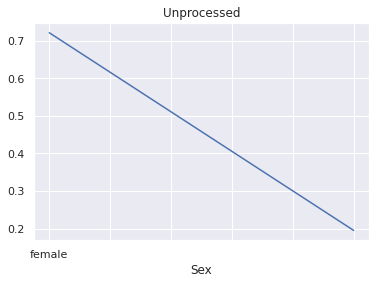

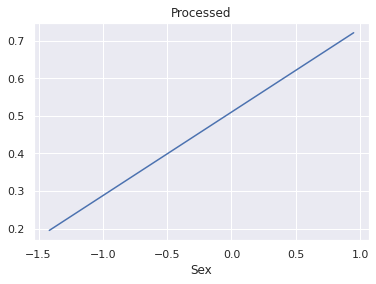

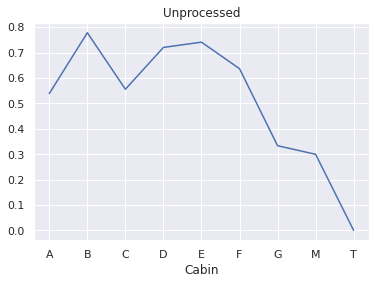

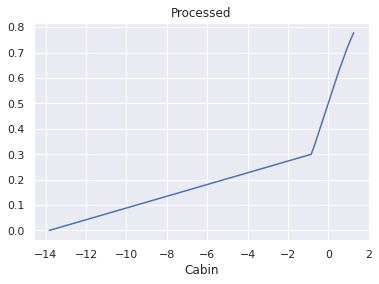

In [22]:
monotony_plot(X_train, X_train_encoded, y_train, cats)